# Computational Intelligence - PART-A

## Predicting Alzheimer's Disease using Neural Nets

In [408]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gc

from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader

In [409]:
def load_dataset(filename):
    try:
        data = pd.read_csv(filename)
        print(f"Dataset loaded successfully: {filename}")
        return data
    except FileNotFoundError:
        print(f"File {filename} not found.")

In [410]:
def set_seed(seed=42):
    import random
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

set_seed()

### EDA

In [411]:
file_name = 'alzheimers_disease_data.csv'
dataset = load_dataset(file_name)
dataset.head()

Dataset loaded successfully: alzheimers_disease_data.csv


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [412]:
print("Dataset Info:")
dataset.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 no

In [413]:
print("Summary Statistics")
dataset.describe()

Summary Statistics


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,5825.000000,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,620.507185,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5288.000000,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5825.000000,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6362.000000,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [414]:
# Some numerical features below are categorical (ordinal). Because though they have >= 10 categories we check their distribution like the numerical one's for convenience

numerical_columns = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'ADL'
]

categorical_columns = [
    'Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'FamilyHistoryAlzheimers',
    'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
    'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation',
    'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis'
]

def plot_histograms_separate(dataset, numerical_columns):
    for column in numerical_columns:
        # Create a figure with 1 row and 2 columns
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

        # Left subplot: Overall distribution
        sns.histplot(
            data=dataset,
            x=column,
            color="blue",
            kde=True,
            bins=15,
            ax=axes[0]
        )
        axes[0].set_title(f'Overall Distribution of {column}')
        axes[0].set_xlabel(column)
        axes[0].set_ylabel('Frequency')

        # Right subplot: Distribution by diagnosis
        sns.histplot(
            data=dataset,
            x=column,
            hue="Diagnosis",
            palette=["#90CAF9", "#F8A170"],
            kde=True,
            bins=15,
            multiple="layer",
            ax=axes[1],
            alpha=0.6
        )

        handles, labels = axes[1].get_legend_handles_labels()
        axes[1].legend(handles, ['No Alzheimer\'s', 'Alzheimer\'s'])

        axes[1].set_title(f'Distribution of {column} by Diagnosis')
        axes[1].set_xlabel(column)
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

def plot_boxplots(dataset):
    fig, ax = plt.subplots(figsize=(18, 8))

    melted_data = pd.melt(dataset[numerical_columns])

    # Create a single boxplot with all numerical columns
    sns.boxplot(x='variable', y='value', data=melted_data, ax=ax)
    ax.set_title('Boxplots of Numerical Features', fontsize=16)
    ax.set_xlabel('Features')
    ax.set_ylabel('Value')

    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

def plot_categorical_crosstabs():
    for column in categorical_columns:
        if column != 'Diagnosis':  # Skip the Diagnosis column itself
            # Create a figure with 1 row and 2 columns of subplots
            fig, axes = plt.subplots(1, 2, figsize=(20, 7))

            # Create crosstab between current feature and Diagnosis
            crosstab = pd.crosstab(dataset[column], dataset['Diagnosis'])

            if column == 'Gender':
                crosstab.index = ['Male', 'Female']
            elif column == 'Ethnicity':
                crosstab.index = ['Caucasian', 'African American', 'Asian', 'Other']
            elif column == 'EducationLevel':
                crosstab.index = ['None', 'High School', 'Bachelor\'s', 'Higher']
            elif column in ['Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
                          'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
                          'MemoryComplaints', 'BehavioralProblems', 'Confusion',
                          'Disorientation', 'PersonalityChanges',
                          'DifficultyCompletingTasks', 'Forgetfulness']:
                crosstab.index = ['No', 'Yes']

            crosstab.columns = ['No Alzheimer\'s', 'Alzheimer\'s']

            # Plot 1: Raw counts (left subplot)
            ax1 = crosstab.plot(kind='bar', stacked=True, ax=axes[0])
            axes[0].set_title(f'{column} vs. Diagnosis (Counts)', fontsize=14)
            axes[0].set_xlabel(column, fontsize=12)
            axes[0].set_ylabel('Count', fontsize=12)
            axes[0].legend(title='Diagnosis')
            axes[0].set_xticklabels(crosstab.index, rotation=0)

            # Add value labels on the bars
            for container in ax1.containers:
                ax1.bar_label(container, label_type='center', fmt='%d')

            # Plot 2: Normalized percentages (right subplot)
            crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
            ax2 = crosstab_norm.plot(kind='bar', stacked=True, ax=axes[1])
            axes[1].set_title(f'{column} vs. Diagnosis (Normalized %)', fontsize=14)
            axes[1].set_xlabel(column, fontsize=12)
            axes[1].set_ylabel('Percentage (%)', fontsize=12)
            axes[1].legend(title='Diagnosis')
            axes[1].set_xticklabels(crosstab.index, rotation=0)

            # Add percentage labels on the bars
            for container in ax2.containers:
                ax2.bar_label(container, label_type='center', fmt='%.1f%%')

            plt.tight_layout()
            plt.show()

In [415]:
# plot_histograms_separate(dataset, numerical_columns)

In [416]:
# plot_boxplots(dataset)

In [417]:
# plot_categorical_crosstabs()

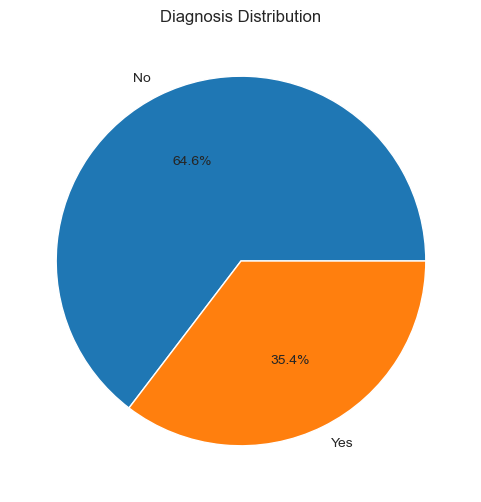

In [418]:
categories = ['No', 'Yes']
counts = dataset.Diagnosis.value_counts().tolist()
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=categories, autopct='%1.1f%%')
plt.title('Diagnosis Distribution')
plt.show()

## A1: Data preprocessing and preparation

### Feature Scaling - Encoding

Perform one-hot encoding for nominal features with more than two categories, avoiding the dummy variable trap and multicollinearity.
Features of the dataset that fall into this category are:
- Ethnicity


Binary features will remain as they are.

In [419]:
def preprocess_dataset(dataset, target_column):
    dataset = dataset.drop(columns=['PatientID', 'DoctorInCharge'])

    # Split into features and target
    X = dataset.drop(columns=[target_column])
    y = dataset[target_column]

    return X, y

In [420]:
def create_and_fit_preprocessors(X_train, features_to_encode, numerical_features):
    # Create and fit encoders on training data
    encoders = {}
    for feature in features_to_encode:
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        encoder.fit(X_train[[feature]])
        encoders[feature] = encoder

    # Create and fit scalers on training data
    c_scaler = None
    mm_scaler = None
    if numerical_features:
        c_scaler = StandardScaler(with_std=False)  # Only center, do not standardize
        c_scaler.fit(X_train[numerical_features])

        mm_scaler = MinMaxScaler()
        mm_scaler.fit(X_train[numerical_features])

    return encoders, c_scaler, mm_scaler


## A2 - A5

In [421]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1, activation='relu', dropout_rate=0.0):
        super(Net, self).__init__()

        # Check input_sizes
        if not isinstance(hidden_sizes, list) or len(hidden_sizes) == 0:
            raise ValueError("Hidden sizes must be a non-emtpy list")

        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'tanh':
            self.activation = nn.Tanh()
        elif activation.lower() == 'silu':
            self.activation = nn.SiLU()
        else:
            raise ValueError(f'Activation {activation} is not supported.')

        # Construct layers based on the size of the hidden_sizes list
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(self.activation)

            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))

            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_size))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [422]:
def get_hidden_sizes(input_size):
    H1 = input_size // 2
    H2 = 2 * input_size // 3
    H3 = input_size
    H4 = 2 * input_size
    return [H1, H2, H3, H4]

In [423]:
def create_model_instance(input_size, hidden_sizes, config):
    # Create model instance
    model = Net(input_size, hidden_sizes, activation=config['activation'], dropout_rate=config['dropout_rate'])

    # Define loss function for binary classification
    loss_fun = nn.BCELoss()

    # Define optimizer
    if 'weight_decay' in config:
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'], weight_decay=config['weight_decay'])
    elif 'momentum' in config:
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

    return model, loss_fun, optimizer

In [424]:
def train(model, train_loader, val_loader, loss_fun, optimizer, device, config, verbose=2):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    train_accuracies = []
    val_accuracies = []
    train_mse = []
    val_mse = []

    patience = config['patience']
    counter = 0
    best_model = None

    mse_loss = nn.MSELoss()

    model.to(device)
    model.double()

    epoch_range = tqdm(range(config['num_epochs'])) if verbose == 2 else range(config['num_epochs'])
    for epoch in epoch_range:
        # Train model
        model.train()
        batch_loss = 0.0
        batch_mse = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Perform forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fun(outputs, labels)

            # Perform backward pass
            loss.backward()
            optimizer.step()

            batch_loss += loss.item() * inputs.size(0)

            batch_mse += mse_loss(outputs, labels).item() * inputs.size(0)

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Epoch metrics calculation
        epoch_train_loss = batch_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        epoch_train_mse = batch_mse / len(train_loader.dataset)

        # Epoch metrics storage
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        train_mse.append(epoch_train_mse)

        # Evaluate model
        model.eval()
        batch_loss = 0.0
        batch_mse = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = loss_fun(outputs, labels)
                batch_loss += loss.item() * inputs.size(0)

                mse = mse_loss(outputs, labels)
                batch_mse += mse.item() * inputs.size(0)

                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Epoch metrics calculation for validation
        epoch_val_loss = batch_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total
        epoch_val_mse = batch_mse / len(val_loader.dataset)

        # Epoch metrics storage for validation
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        val_mse.append(epoch_val_mse)

        if verbose == 2:
             print(f'Epoch {epoch+1}/{config["num_epochs"]} - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train MSE: {epoch_train_mse:.4f}, Train Acc: {epoch_train_acc:.4f} - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val MSE: {epoch_val_mse:.4f}, Val Acc: {epoch_val_acc:.4f}')
        elif verbose == 1 and ((epoch+1) % 5 == 0 or epoch == 0):
            print(f'Epoch {epoch+1}/{config["num_epochs"]} - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train MSE: {epoch_train_mse:.4f}, Train Acc: {epoch_train_acc:.4f} - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val MSE: {epoch_val_mse:.4f}, Val Acc: {epoch_val_acc:.4f}')

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
            best_model = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

    model.load_state_dict(best_model)

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_mse': train_mse,
        'val_mse': val_mse,
        'best_val_loss': best_val_loss
    }

In [425]:
def apply_fold_preprocessing(X_train, X_val, y_train, y_val,features_to_encode, numerical_features, config):
    X_train_processed = X_train.copy()
    X_val_processed = X_val.copy()

    # Create and fit preprocessors using only training data
    encoders, c_scaler, mm_scaler = create_and_fit_preprocessors(
        X_train, features_to_encode, numerical_features
    )

    # Apply one-hot encoding
    for feature in features_to_encode:
        encoder = encoders[feature]

        train_encoded = encoder.transform(X_train[[feature]])
        val_encoded = encoder.transform(X_val[[feature]])

        feature_names = []
        categories = list(encoder.categories_[0])
        for category in categories[1:]:
            feature_names.append(f"{feature}_{category}")

        train_encoded_df = pd.DataFrame(train_encoded, columns=feature_names, index=X_train.index)
        val_encoded_df = pd.DataFrame(val_encoded, columns=feature_names, index=X_val.index)

        X_train_processed = X_train_processed.drop(columns=[feature])
        X_val_processed = X_val_processed.drop(columns=[feature])
        X_train_processed = pd.concat([X_train_processed, train_encoded_df], axis=1)
        X_val_processed = pd.concat([X_val_processed, val_encoded_df], axis=1)

    if numerical_features and c_scaler and mm_scaler:
        X_train_processed[numerical_features] = c_scaler.transform(X_train_processed[numerical_features])
        X_val_processed[numerical_features] = c_scaler.transform(X_val_processed[numerical_features])

        X_train_processed[numerical_features] = mm_scaler.transform(X_train_processed[numerical_features])
        X_val_processed[numerical_features] = mm_scaler.transform(X_val_processed[numerical_features])

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_processed.values, dtype=torch.float64)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_processed.values, dtype=torch.float64)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float64).view(-1, 1)

    # Create tensor datasets
    train_tensor_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_tensor_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Create dataloaders
    train_loader = DataLoader(train_tensor_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=config['batch_size'], shuffle=True)

    input_size = X_train_processed.shape[1]

    return train_loader, val_loader, input_size

### 5-fold CV

In [426]:
def create_combined_training_plot(all_fold_metrics, title_str, param_str):
    """Create a combined plot of training loss across all folds"""
    plt.figure(figsize=(12, 8))

    # Define colors for each fold
    colors = ['blue', 'orange', 'green', 'red', 'purple']

    # Plot training loss for each fold
    for fold, metrics in enumerate(all_fold_metrics):
        plt.plot(metrics['train_losses'], label=f'Fold {fold+1}', color=colors[fold % len(colors)])

    plt.title(f"Training Loss Across Folds - {title_str}")
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.legend()
    plt.grid(True)

    # Save the combined plot
    plt.savefig(f"plots/combined_training_loss_{param_str}.png")
    plt.close()

def create_combined_validation_plot(all_fold_metrics, title_str, param_str):
    """Create a combined plot of validation loss across all folds"""
    plt.figure(figsize=(12, 8))

    # Define colors for each fold
    colors = ['blue', 'orange', 'green', 'red', 'purple']

    # Plot validation loss for each fold
    for fold, metrics in enumerate(all_fold_metrics):
        plt.plot(metrics['val_losses'], label=f'Fold {fold+1}', color=colors[fold % len(colors)])

    plt.title(f"Validation Loss Across Folds - {title_str}")
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)

    # Save the combined plot
    plt.savefig(f"plots/combined_validation_loss_{param_str}.png")
    plt.close()


In [427]:
def run_kfold_cv_for_param(k_fold, X_train_val, y_train_val, hidden_size, features_to_encode, numerical_features,
                           config, device, experiment_type, verbose=1):
    """Helper function to run k-fold CV for a specific parameter configuration"""

    # Initialize dictionaries to store results for this parameter value
    fold_results = {
        'ce_loss': [],
        'mse': [],
        'accuracy': [],
        'best_val_loss': []
    }

    all_fold_metrics = []

    title_str='--'
    param_str='--'

    # Perform k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(X_train_val, y_train_val)):
        if verbose >= 1:
            print(f"\n{'='*10} Fold {fold+1}/{config['n_folds']} {'='*10}")

        # Split the data for this fold
        X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

        # Apply preprocessing for this fold
        train_loader, val_loader, _ = apply_fold_preprocessing(
            X_train_fold, X_val_fold, y_train_fold, y_val_fold,
            features_to_encode, numerical_features, config
        )

        # Create model instance
        net, loss_fun, optimizer = create_model_instance(input_size, hidden_size, config)

        # Train model
        net, metrics = train(net, train_loader, val_loader, loss_fun, optimizer, device, config, verbose)

        # Extract metrics
        ce_loss = metrics['val_losses'][-1]
        mse = metrics['val_mse'][-1]
        accuracy = metrics['val_accuracies'][-1]
        best_val_loss = metrics['best_val_loss']

        if verbose >= 1:
            print(f"Fold {fold+1} Results - CE Loss: {ce_loss:.4f}, MSE: {mse:.4f}, Accuracy: {accuracy:.4f}")

        # Store results for this fold
        fold_results['ce_loss'].append(ce_loss)
        fold_results['mse'].append(mse)
        fold_results['accuracy'].append(accuracy)
        fold_results['best_val_loss'].append(best_val_loss)

        all_fold_metrics.append(metrics)

        # Generate plot title and filename
        if experiment_type == 'activation':
            param_str = f"act_{config['activation']}"
            title_str = f"Activation={config['activation']}, LR={config['learning_rate']}, Hidden Size={config['hidden_size']}"
        elif experiment_type == 'weight_decay':
            param_str = f"wd{config['weight_decay']}"
            title_str = f"Weight Decay={config['weight_decay']}, Hidden Size={config['hidden_size']}, LR={config['learning_rate']}, Momentum={config['momentum']}, Activation={config['activation']}"
        elif experiment_type == 'lr_momentum':
            param_str = f"lr{config['learning_rate']}_mom{config['momentum']}"
            title_str = f"LR={config['learning_rate']}, Momentum={config['momentum']}, Hidden Size={config['hidden_size']}, Activation={config['activation']}"
        elif experiment_type == 'deep_net':
            # Deep network
            param_str = f"layers_{'x'.join(str(x) for x in hidden_size)}"
            title_str = f"Layers={hidden_size}, Weight Decay={config['weight_decay']}, LR={config['learning_rate']}, Momentum={config['momentum']}, Activation={config['activation']}"
        elif experiment_type == 'hidden_size':
            # Single hidden layer
            h_size = hidden_size[0] if isinstance(hidden_size, list) else hidden_size
            param_str = f"h{h_size}"
            title_str = f"Hidden Size={h_size}, LR={config['learning_rate']}"

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Create combined plots after all folds are finished
    create_combined_training_plot(all_fold_metrics, title_str, param_str)
    create_combined_validation_plot(all_fold_metrics, title_str, param_str)

    # Calculate average results across all folds
    avg_results = {metric: np.mean(values) for metric, values in fold_results.items()}

    return avg_results

In [428]:
def stratified_k_fold(X_train_val, y_train_val, experiment_config, base_config, features_to_encode, numerical_features, verbose=2):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    os.makedirs("plots/", exist_ok=True)

    # Init stratified k-fold cross validation
    k_fold = StratifiedKFold(n_splits=base_config['n_folds'], shuffle=True, random_state=42)

    experiment_type = experiment_config['type']
    experiment_results = {}

    if experiment_type == 'hidden_size':
        hidden_sizes = experiment_config['hidden_sizes']

        for hidden_size in hidden_sizes:
            if verbose >= 1:
                 print(f"\n{'='*20} Testing hidden size: {hidden_size[0]} {'='*20}")

            # Run k-fold CV for this hidden size
            results = run_kfold_cv_for_param(
                k_fold, X_train_val, y_train_val, hidden_size=hidden_size,
                features_to_encode=features_to_encode, numerical_features=numerical_features,
                config=base_config, device=device, experiment_type=experiment_type, verbose=verbose
            )

            experiment_results[hidden_size[0]] = results

    elif experiment_type == 'activation':
        # For activation function experiments
        activation_functions = experiment_config['functions']
        hidden_size = experiment_config['hidden_size']

        for activation in activation_functions:
            if verbose >= 1:
                print(f"\n{'='*20} Testing activation function: {activation} {'='*20}")

            # Create modified config with the activation function
            temp_config = base_config.copy()
            temp_config['activation'] = activation
            temp_config['hidden_size'] = hidden_size

            # Run k-fold CV for this activation function
            results = run_kfold_cv_for_param(
                k_fold, X_train_val, y_train_val, hidden_size=hidden_size,
                features_to_encode=features_to_encode, numerical_features=numerical_features,
                config=temp_config, device=device, experiment_type=experiment_type, verbose=verbose
            )

            experiment_results[activation] = results

    elif experiment_type == 'lr_momentum':
        # For lr_momentum experiments, we test specific combinations
        param_combinations = experiment_config['combinations']
        hidden_size = experiment_config['hidden_size']

        for lr, momentum in param_combinations:
            if verbose >= 1:
                print(f"\n{'='*20} Testing lr={lr}, momentum={momentum} {'='*20}")

            # Create modified config for this combination
            temp_config = base_config.copy()
            temp_config['learning_rate'] = lr
            temp_config['momentum'] = momentum
            temp_config['hidden_size'] = hidden_size

            # Run k-fold CV for this combination
            results = run_kfold_cv_for_param(
                k_fold, X_train_val, y_train_val, hidden_size=hidden_size,
                features_to_encode=features_to_encode, numerical_features=numerical_features,
                config=temp_config, device=device, experiment_type=experiment_type, verbose=verbose
            )

            experiment_results[(lr, momentum)] = results

    elif experiment_type == 'weight_decay':
        # For weight decay experiments
        weigh_decay_values = experiment_config['weight_decay']
        hidden_size = experiment_config['hidden_size']

        learning_rate = experiment_config['learning_rate']
        momentum = experiment_config['momentum']

        for weight_decay in weigh_decay_values:
            if verbose >= 1:
                print(f"\n{'='*20} Testing weight decay: {weight_decay} {'='*20}")



            # Create modified config with the weight decay value
            temp_config = base_config.copy()
            temp_config['learning_rate'] = learning_rate
            temp_config['momentum'] = momentum
            temp_config['weight_decay'] = weight_decay
            temp_config['hidden_size'] = hidden_size

            # Run k-fold CV for this weight decay
            results = run_kfold_cv_for_param(
                k_fold, X_train_val, y_train_val, hidden_size=hidden_size,
                features_to_encode=features_to_encode, numerical_features=numerical_features,
                config=temp_config, device=device, experiment_type=experiment_type, verbose=verbose
            )

            experiment_results[weight_decay] = results

    elif experiment_type == 'deep_net':
        layer_configs = experiment_config['layer_configs']

        learning_rate = experiment_config['learning_rate']
        momentum = experiment_config['momentum']
        weight_decay = experiment_config['weight_decay']
        dropout_rate = experiment_config['dropout_rate']

        for layer_config in layer_configs:
            config_name = "x".join([str(size) for size in layer_config])
            if verbose >= 1:
                print(f"\n{'='*20} Testing layer configuration: {config_name} {'='*20}")

            temp_config = base_config.copy()
            temp_config['learning_rate'] = learning_rate
            temp_config['momentum'] = momentum
            temp_config['weight_decay'] = weight_decay
            temp_config['dropout_rate'] = dropout_rate

            # Run k-fold CV for this layer configuration
            results = run_kfold_cv_for_param(
                k_fold, X_train_val, y_train_val,
                hidden_size=layer_config,
                features_to_encode=features_to_encode, numerical_features=numerical_features,
                config=temp_config, device=device, experiment_type=experiment_type, verbose=verbose
            )

            experiment_results[tuple(layer_config)] = results


    # Print summary table
    print("\n" + "="*60)
    print(f"Summary Results Table - {experiment_type}")
    print("="*60)

    if experiment_type == 'lr_momentum':
        print(f"{'Learning Rate':<15} {'Momentum':<15} {'CE Loss':<15} {'MSE':<15} {'Accuracy':<15}")
        print("-"*75)
        for (lr, momentum) in experiment_results:
            result = experiment_results[(lr, momentum)]
            print(f"{lr:<15} {momentum:<15} {result['ce_loss']:<15.4f} "
                  f"{result['mse']:<15.4f} {result['accuracy']:<15.4f}")
    elif experiment_type == 'activation':
        print(f"{'Activation':<15} {'CE Loss':<15} {'MSE':<15} {'Accuracy':<15}")
        print("-"*60)
        for activation in experiment_results:
            result = experiment_results[activation]
            print(f"{activation:<15} {result['ce_loss']:<15.4f} "
                  f"{result['mse']:<15.4f} {result['accuracy']:<15.4f}")
    elif experiment_type == 'deep_net':
        print(f"{'Layer Config':<25} {'CE Loss':<15} {'MSE':<15} {'Accuracy':<15}")
        print("-"*70)
        for base_config in experiment_results:
            result = experiment_results[base_config]
            # Format the layer configuration as a string
            config_str = "x".join([str(size) for size in base_config])
            print(f"{config_str:<25} {result['ce_loss']:<15.4f} "
                  f"{result['mse']:<15.4f} {result['accuracy']:<15.4f}")
    else:
        param_name = {'hidden_size': 'Hidden Size', 'weight_decay': 'Weight Decay'}[experiment_type]
        print(f"{param_name:<15} {'CE Loss':<15} {'MSE':<15} {'Accuracy':<15}")
        print("-"*60)
        for param in experiment_results:
            result = experiment_results[param]
            print(f"{param:<15} {result['ce_loss']:<15.4f} "
                  f"{result['mse']:<15.4f} {result['accuracy']:<15.4f}")

    return experiment_results

In [429]:
target_column = 'Diagnosis'
features_to_encode = ['Ethnicity']

numerical_columns = [
    'Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
    'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal',
    'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides',
    'MMSE', 'FunctionalAssessment', 'ADL'
]

config = {
    # Core parameters
    'n_folds': 5,
    'batch_size': 16,
    'input_size': 34,
    'num_epochs': 2000,
    'patience': 10,

    # Default hyperparameters (might be overridden in some experiments)
    'learning_rate': 0.001,
    'momentum': 0.0,
    'activation': 'relu',
    'weight_decay': 0.0,
    'dropout_rate': 0.0
}

verbose = 0

# Preprocess dataset
X, y = preprocess_dataset(dataset, target_column)

input_size = config['input_size']

hidden_size_config = {
    'type': 'hidden_size',
    'hidden_sizes': [[size] for size in get_hidden_sizes(input_size)] # List of single element lists
}

activation_config = {
    'type': 'activation',
    'functions': ['relu', 'tanh', 'silu'],
    'hidden_size': [34]  # Use best hidden size from A2 experiment
}

lr_momentum_config = {
    'type': 'lr_momentum',
    'combinations': [
        (0.001, 0.2),  # First combination: learning_rate=0.001, momentum=0.2
        (0.001, 0.6),  # Second combination: learning_rate=0.001, momentum=0.6
        (0.05, 0.6),   # Third combination: learning_rate=0.05, momentum=0.6
        (0.1, 0.6)     # Fourth combination: learning_rate=0.1, momentum=0.6
    ],
    'hidden_size': [4]
}

weight_decay_config = {
    'type': 'weight_decay',
    'weight_decay': [0.0001, 0.001, 0.01],
    'learning_rate': 0.001,
    'momentum': 0.2,
    'hidden_size': [4]
}

deep_net_config = {
    'type': 'deep_net',
    'layer_configs': [
        # Two hidden layers
        [input_size//2, input_size//2],               # Same size
        [input_size, input_size//2],                  # Decreasing
        [input_size//2, input_size],                  # Increasing

        # Three hidden layers
        [input_size//2, input_size//2, input_size//2], # Same size
        [input_size, input_size//2, input_size//4],     # Decreasing
        [input_size//4, input_size//2, input_size]      # Increasing
    ],
    'weight_decay': 0.0001,
    'momentum': 0.2,
    'learning_rate': 0.001,
}

exp_config = hidden_size_config

experiment_results = stratified_k_fold(
    X,
    y,
    exp_config,
    config,
    features_to_encode,
    numerical_columns,
    verbose=verbose  # Set verbosity level
)

Early stopping triggered at epoch 533
Early stopping triggered at epoch 565
Early stopping triggered at epoch 443
Early stopping triggered at epoch 421
Early stopping triggered at epoch 511
Early stopping triggered at epoch 558
Early stopping triggered at epoch 523
Early stopping triggered at epoch 434
Early stopping triggered at epoch 462
Early stopping triggered at epoch 474
Early stopping triggered at epoch 482
Early stopping triggered at epoch 553
Early stopping triggered at epoch 446
Early stopping triggered at epoch 437
Early stopping triggered at epoch 528
Early stopping triggered at epoch 709
Early stopping triggered at epoch 567
Early stopping triggered at epoch 478
Early stopping triggered at epoch 391
Early stopping triggered at epoch 438

Summary Results Table - hidden_size
Hidden Size     CE Loss         MSE             Accuracy       
------------------------------------------------------------
17              0.3882          0.1199          0.8357         
22            